`Name:` Chris Andrei Irag
`Section:` DS4A

## Summary

This notebook as an assignment in DS412 Time Series Analysis and Stochastic Processes. This notebook models a dataset of 'Monthly Mean Total Sunspot numbers' using ARIMA. We use computational methods to optimize the ARIMA model. We perform exploratory data analysis to get a good idea on how to perform modeling. We resulted an RMSE score of 9.8 in our final fitted model.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

df = pd.read_csv("Sunspots_.csv").drop("Unnamed: 0", axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3247,2019-08-31,0.5
3248,2019-09-30,1.1
3249,2019-10-31,0.4
3250,2019-11-30,0.5


We load in the data 'Sunspots_.csv' which has two columns, `Date` and `Monthly Mean Total Sunspot Number`. `Date` has a monthly temporal resolution.

## Exploratory Data Analysis

<Axes: xlabel='Date', ylabel='Monthly Mean Total Sunspot Number'>

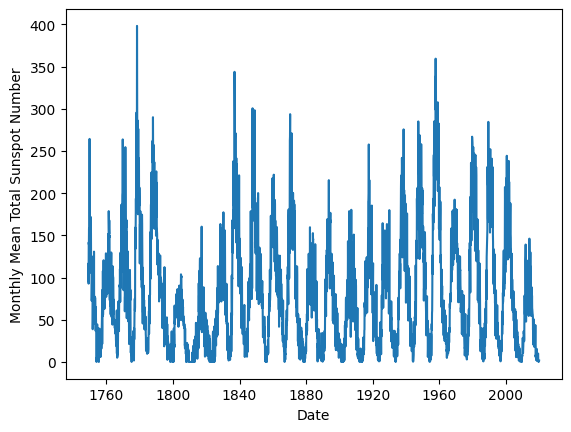

In [19]:
sns.lineplot(df, x="Date", y="Monthly Mean Total Sunspot Number")

The whole dataset doesn't seem to have any seasonality but shows some cyclicity.

In [20]:
filtered_df = df[df['Date'] > df["Date"].max() - pd.DateOffset(years=5)].reset_index().drop("index", axis=1)
filtered_df

,Date,Monthly Mean Total Sunspot Number
0,2015-01-31,93.0
1,2015-02-28,66.7
2,2015-03-31,54.5
3,2015-04-30,75.3
4,2015-05-31,88.8
5,2015-06-30,66.5
6,2015-07-31,65.8
7,2015-08-31,64.4
8,2015-09-30,78.6
9,2015-10-31,63.6


<Axes: xlabel='Date', ylabel='Monthly Mean Total Sunspot Number'>

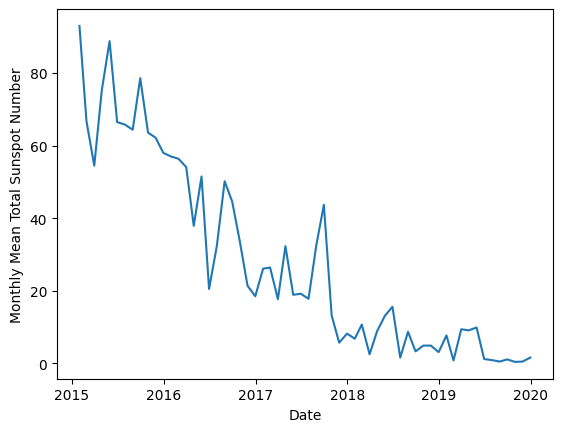

In [21]:
sns.lineplot(filtered_df, x="Date", y="Monthly Mean Total Sunspot Number")

However, with filtered data from the last five years, there is a downward trend.

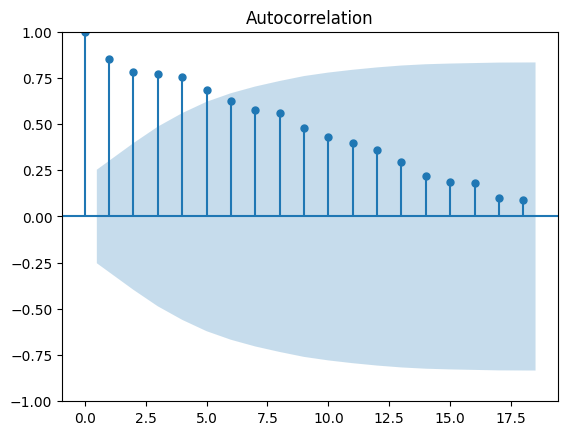

In [22]:
plt.show(plot_acf(filtered_df["Monthly Mean Total Sunspot Number"]))

Plotting the ACF shows us that their is a clear trend and distribution change over time, and will require differencing for ARIMA fitting.

In [23]:
df["Date"]

0      1749-01-31
1      1749-02-28
2      1749-03-31
3      1749-04-30
4      1749-05-31
          ...    
3247   2019-08-31
3248   2019-09-30
3249   2019-10-31
3250   2019-11-30
3251   2019-12-31
Name: Date, Length: 3252, dtype: datetime64[ns]

In [24]:
df["Monthly Mean Total Sunspot Number"].describe()

count    3252.000000
mean       82.070695
std        67.864736
min         0.000000
25%        24.200000
50%        67.750000
75%       122.700000
max       398.200000
Name: Monthly Mean Total Sunspot Number, dtype: float64

<Axes: ylabel='Count'>

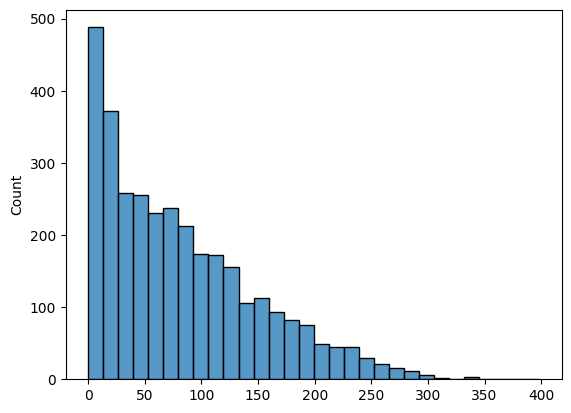

In [25]:
sns.histplot(df["Monthly Mean Total Sunspot Number"].to_list())

The data shows a non-normal distribution.

EDA Summary

- The time series data has a monthly temporal resolution.
- There is a downward trend.
- The data is not stationary according to the ACF plot and will need differencing
- The monthly mean total sunspot counts is not normally distributed.

# Modeling

We'll use ARIMA to model our problem, which we will computationally optimize by trying out combinations of varying orders of AR(p) and MA(q) models. We will only be differencing the data once so we'll use I(d) of order one.

These combinations are simply a cartesian product of all choices for each parameter. Which will be represented as `range` objects in the `ARIMAOptimizer` class. The `ARIMAOptimizer` class `_combinations` property we can call to get all cartesion combinations of our parameters, and an `optimize` method that finds the model configuration that best minimizes Akaike Information Criterion (AIC) score. The optimization results are stored as an instance property `self.results`.

In [ ]:
from itertools import product

from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm

type Combination = tuple[int, int, int]
type AICScore = float
type Result = tuple[Combination, AICScore]

class ARIMAOptimizer:
    """
    A class for automatic ARIMA model selection based on the Akaike Information Criterion (AIC).

    This utility searches over combinations of (p, d, q) parameters for an ARIMA model
    and returns the model with the lowest AIC score.

    Attributes
    ----------
    p : range
        Range of AR (autoregressive) parameters to test.
    d : range
        Range of differencing parameters to test.
    q : range
        Range of MA (moving average) parameters to test.
    data : pd.Series
        The time series data used for model fitting.
    results : list
        Stores tuples of tested parameter combinations and their corresponding AIC values.

    Methods
    -------
    silence_warnings():
        Silences warnings from statsmodels during model fitting.
    optimize():
        Iterates over all parameter combinations, fits SARIMAX models, and returns the best one.
    """
    def __init__(
        self, p: range, d: range, q: range, data: pd.Series, silence_warnings=True
    ) -> None:
        """
        Initializes the ARIMAOptimizer with parameter ranges and data.

        Parameters
        ----------
        p : range
            Range of AR (autoregressive) parameters.
        d : range
            Range of differencing parameters.
        q : range
            Range of MA (moving average) parameters.
        data : pd.Series
            The time series data to fit models on.
        silence_warnings : bool, optional
            Whether to suppress warnings during optimization (default is True).
        """
        self.p = p
        self.d = d
        self.q = q
        self.data = data
        self.results: list[Result] = []

        if silence_warnings:
            self.silence_warnings()

    @property
    def _combinations(self) -> list[Combination]:
        """
        Generates all combinations of (p, d, q) parameters.

        Returns
        -------
        list
            A list of tuples, each representing a (p, d, q) combination.
        """
        parameters = [self.p, self.d, self.q]
        return list(product(*parameters))

    @staticmethod
    def silence_warnings() -> None:
        """
        Silences warnings from statsmodels to avoid noisy output during model fitting.
        Particular exceptions like convergence warnings will be ignored.
        """
        import warnings
        warnings.filterwarnings("error")

    def optimize(self) -> SARIMAX:
        """
        Fits SARIMAX models across all (p, d, q) combinations and selects the best one based on AIC.

        Returns
        -------
        SARIMAX
            The best-fitted SARIMAX model with the lowest AIC value.

        Notes
        -----
        - The function uses `tqdm` to display a progress bar for the combinations tested.
        - Models that fail to converge or raise errors are skipped.
        """
        best_aic = float("inf")
        best_fitted_model = None

        for combination in tqdm(self._combinations):

            try:
                model = SARIMAX(
                    self.data, order=combination, simple_differencing=False
                )
                fitted_model = model.fit(disp=False)
            except Exception:
                continue
            self.results.append((combination, fitted_model.aic))

            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_fitted_model = fitted_model

        return best_fitted_model


In [11]:
optimizer = ARIMAOptimizer(range(11), range(1, 2), range(11), data=filtered_df["Monthly Mean Total Sunspot Number"])
best_model = optimizer.optimize()

  0%|          | 0/121 [00:00<?, ?it/s]

In [12]:
results = pd.DataFrame(optimizer.results, columns=["(p, d, q)", "AIC Score"])
results

,"(p, d, q)",AIC Score
0,"(0, 1, 0)",452.059203
1,"(0, 1, 1)",445.674356
2,"(0, 1, 2)",445.524594
3,"(0, 1, 3)",446.107184
4,"(0, 1, 4)",444.534666
5,"(0, 1, 5)",443.979313
6,"(1, 1, 0)",451.337532
7,"(1, 1, 2)",447.314103
8,"(1, 1, 4)",444.423618
9,"(1, 1, 5)",445.972321


In [13]:
results[results["AIC Score"] == results["AIC Score"].min()]

,"(p, d, q)",AIC Score
14,"(3, 1, 0)",442.650172


We converge to a combination of orders AR(3), I(1), and MA(0). As expected of the ACF plot, the model difference the data once. It seems that not using the MA component is better, and only utilizing 3 lags of an autoregressive model, implying that only 3 lags worth of information is needed to influence the next prediction.

<Axes: ylabel='Count'>

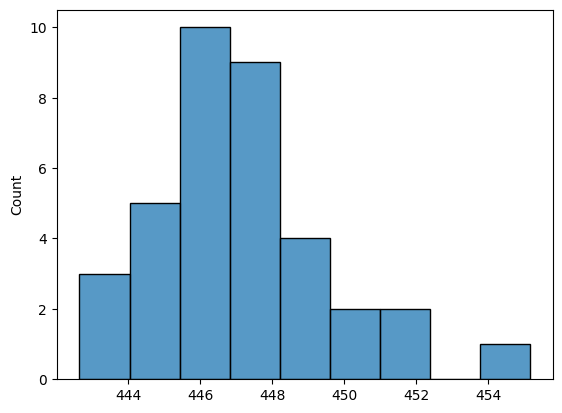

In [14]:
sns.histplot(results["AIC Score"].to_list())

Modeling Summary

- We used the `ARIMAOptimizer` class to encapsulate the logic of computationally finding the best fitting ARIMA mode to our data.
- AR(3), I(1), and MA(0) is the best fitting ARIMA model with AIC score 442.65.

# Prediction

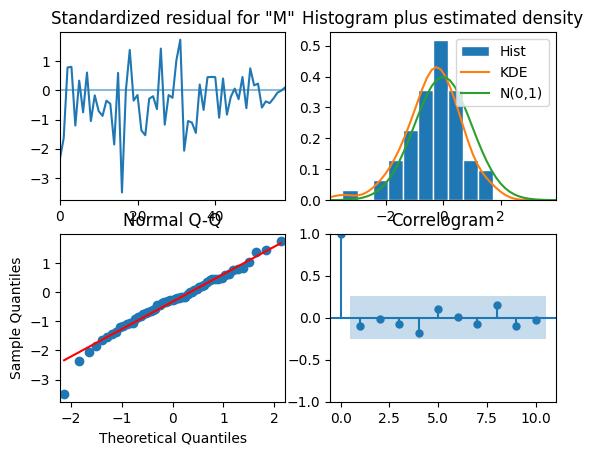

In [15]:
plt.show(best_model.plot_diagnostics())

Our residuals are normally distributed according to the QQ and histogram plots, the a differencing order of 1 made the the stationary as displaying on the correlogram, with all of the lags within the significance region.

We forecast 24 months beyond the latest date available in the data starting from the the last 5 years.

In [16]:
n_forecast = 24

predictions = best_model.get_prediction(end=best_model.nobs + n_forecast)
predictions.predicted_mean


0      0.000000
1     92.997528
2     72.358618
3     67.305034
4     81.067880
        ...    
80     1.072519
81     1.073726
82     1.073104
83     1.072314
84     1.072513
Name: predicted_mean, Length: 85, dtype: float64

Plot the results. We manually add a date range to accompy the results. `pd.DateOffset` is an object that represents a block of time that can be added/subtracted to `timestamp`-like objects. We specify the temporal resolution / frequency "ME" or Monthly End, so every ending day of every month.


We skip the first element since AR models don't have any preceding values as input to the first time step, resulting in null/empty/zero values depending on the implementation.

<Axes: xlabel='Date', ylabel='Monthly Mean Total Sunspot Number'>

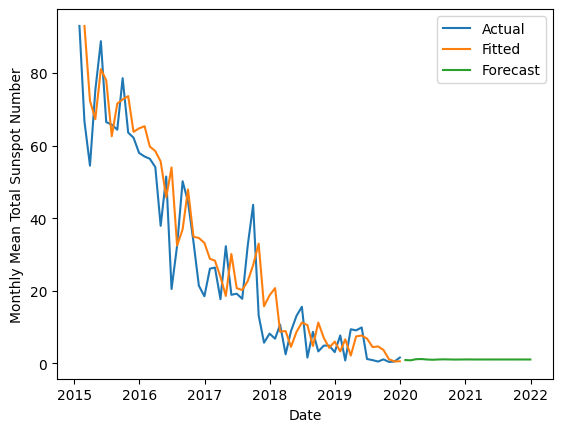

In [ ]:
prediction_date_range = pd.date_range(
    filtered_df["Date"].max() + pd.DateOffset(months=1),
    filtered_df["Date"].max() + pd.DateOffset(months=n_forecast),
    freq="ME",
)


sns.lineplot(data=filtered_df, x='Date', y="Monthly Mean Total Sunspot Number", label="Actual")
                                                # We skip the first fitted point to ignore empty values
sns.lineplot(data=filtered_df, x='Date', y=predictions.predicted_mean[:-n_forecast][1:], label="Fitted")
sns.lineplot(x=prediction_date_range, y=predictions.predicted_mean[-n_forecast:], label="Forecast")

Visually, our fitted model follows the downard trend, then forecasts a relatively flat behaviour beyond year 2020.

### RMSE

In [18]:
rmse = root_mean_squared_error(
    filtered_df["Monthly Mean Total Sunspot Number"][1:],
    predictions.predicted_mean[1: len(filtered_df)],
)
rmse

9.796508215230842

Our best fitted model has an root mean squared error (RMSE) of 9.796, which is pretty decent considering the domain and magnitude of the data. An RMSE error of 9.796 means that on average we get 9.76 rooted squared errors of monthly mean sunspot counts, which is a better representation that intends to refer to the actual unit of the data.

Prediction Summary

- Our best fitted model has an RMSE of 9.796 on the training data.
- The fitted model fits the data nicely.